In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def DealWithTime(data):
    data['time'] = pd.to_datetime(data['timestamp'])
    return data

In [3]:
def GetData(filename):
    data = pd.read_csv(filename)
    data = data[['loggingTime(txt)','motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)',\
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',\
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']]
    colums_name = ['timestamp','accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'yaw','roll', 'pitch']
    data.columns = colums_name
    return data

In [4]:
def Overview(data):
    plt.figure(figsize=(15,20))
    p1 = plt.subplot(3,1,1)
    p2 = plt.subplot(3,1,2)
    p3 = plt.subplot(3,1,3)
    p1.plot(left['accX'])
    p2.plot(left['accY'])
    p3.plot(left['accZ'])
    plt.show()

    plt.figure(figsize=(15,20))
    p4 = plt.subplot(3,1,1)
    p5 = plt.subplot(3,1,2)
    p6 = plt.subplot(3,1,3)
    p4.plot(left['gyroX'])
    p5.plot(left['gyroY'])
    p6.plot(left['gyroZ'])
    plt.show()

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(highcut, fs, order=3):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, highcut, fs, order=3):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def getStepFrequency(data):
    ffted = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(ffted))
    idx = np.argmax(np.abs(ffted))
    freq = freqs[idx]
    return abs(freq*fs)

fs = 30

In [64]:
left = GetData("../dataset/tony_left_2017-11-27_14-43-11_-0800.csv")
right =  GetData("../dataset/tony_right_2017-11-27_14-42-50_-0800.csv")
left = DealWithTime(left)
right = DealWithTime(right)

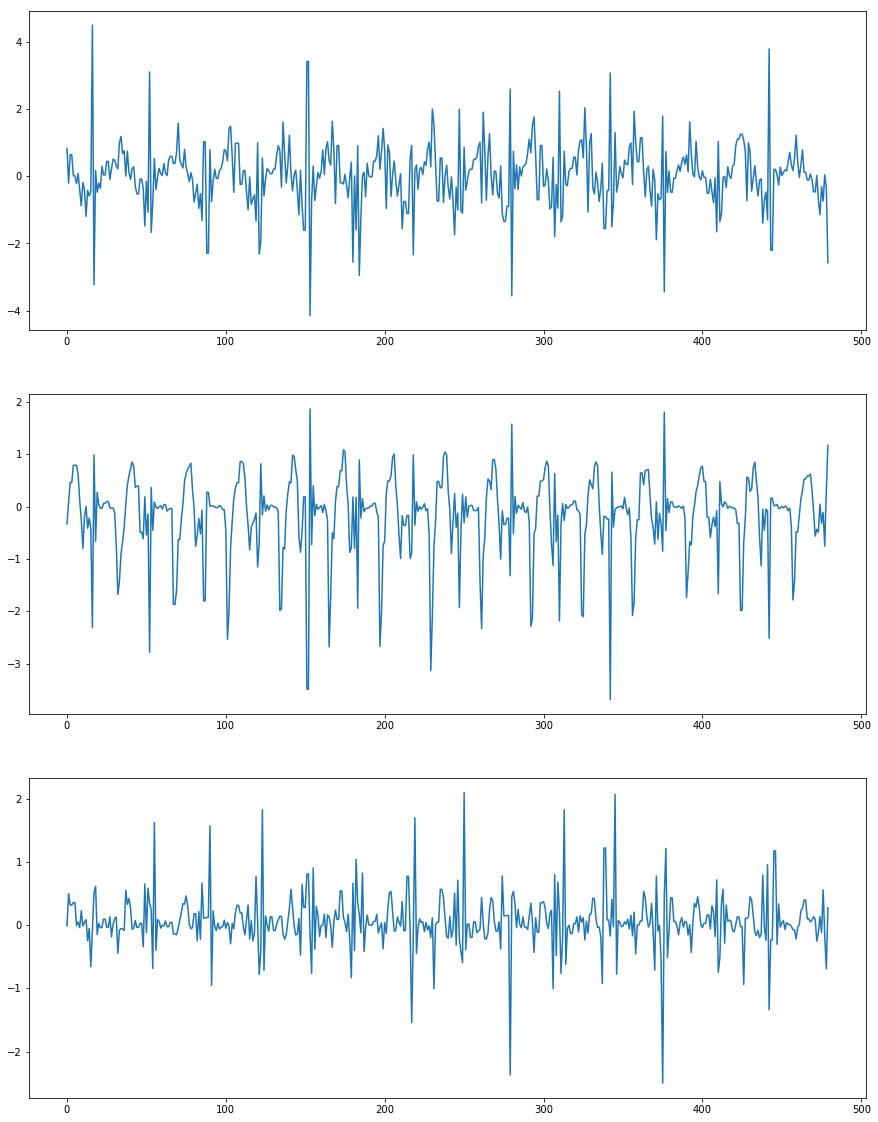

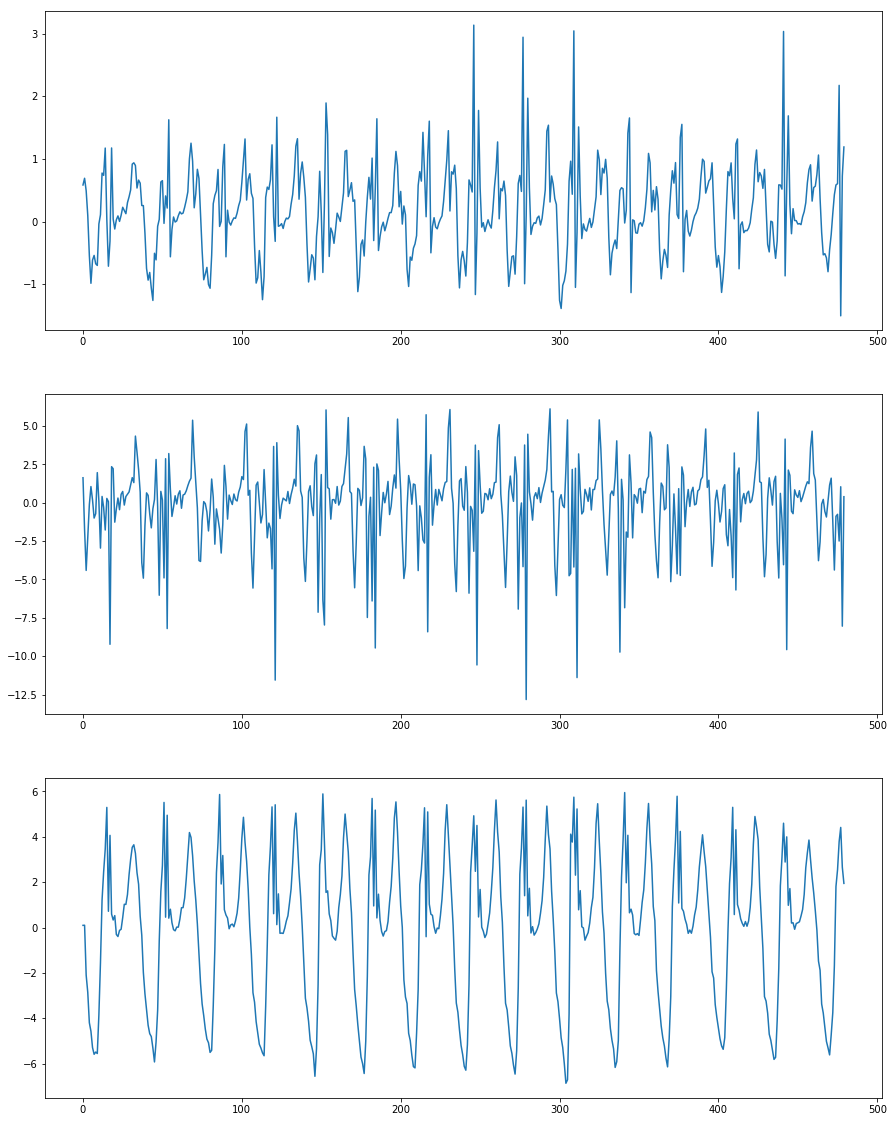

In [65]:
# left = left[857:1300] lzy
# left = left[450:1000] zmq
left = left[620:1100]
left = left.reset_index(drop=True)
Overview(left)

In [66]:
highcut = 6
left['accX'] = butter_lowpass_filter(left['accX'],highcut, fs)
left['accY'] = butter_lowpass_filter(left['accY'],highcut, fs)
left['accZ'] = butter_lowpass_filter(left['accZ'],highcut, fs)

In [67]:
lowcut = 0.08
highcut = 7
left['gyroX'] = butter_bandpass_filter(left['gyroX'],lowcut, highcut, fs)
left['gyroY'] = butter_bandpass_filter(left['gyroY'],lowcut, highcut, fs)
left['gyroZ'] = butter_bandpass_filter(left['gyroZ'],lowcut, highcut, fs)

In [68]:
print(getStepFrequency(left['accY']))
print(getStepFrequency(left['accX']))
print(getStepFrequency(left['accZ']))
print(getStepFrequency(left['gyroY']))
print(getStepFrequency(left['gyroX']))
print(getStepFrequency(left['gyroZ']))

1.875
0.9375
0.0
0.9375
1.875
0.9375


In [124]:
step_frequency = getStepFrequency(left['gyroZ'])

In [125]:
step_cycle = int(round(fs/step_frequency))

In [136]:
def seperateEachStep(data, step_cycle):
    steps = pd.DataFrame()
    idx_list = []
    for i in range(0, data.shape[0], step_cycle):
        idx = np.argmin(data['gyroZ'].iloc[i:i+step_cycle])
        idx_list.append(idx)
    print(idx_list)
    for i in range(0, len(idx_list)-1):
        prev = idx_list[i]
        nxt = idx_list[i+1]
#         interval = nxt - prev
#         floor1 = int(prev + (interval*0.34))
#         floor2 = int(nxt - (interval*0.34))
        while (data['gyroZ'].iloc[prev]<data['gyroZ'].iloc[prev+1]):
            prev +=1
        while (data['gyroZ'].iloc[nxt]<data['gyroZ'].iloc[nxt-1]):
            nxt -=1
        floor1 = prev;
        floor2 = nxt;
        idx = np.argmin(data['gyroZ'].iloc[floor1:floor2])
        steps = steps.append(data.iloc[idx])
    return steps

[8, 45, 80, 113, 146, 177, 208, 241, 272, 304, 335, 368, 403, 435, 470]


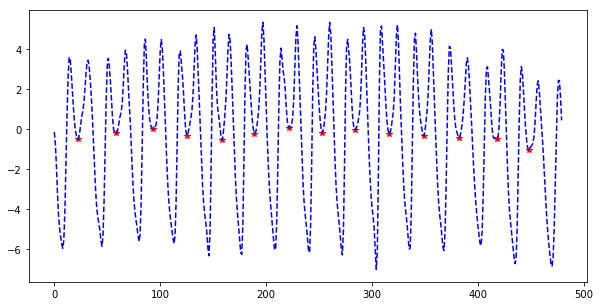

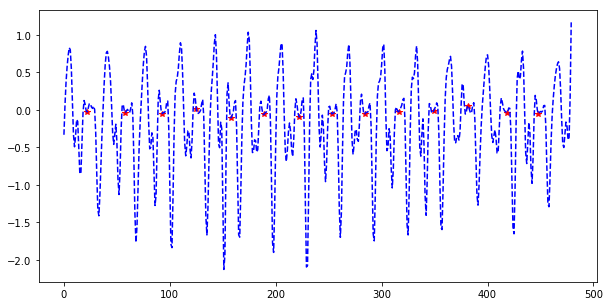

In [137]:
steps = seperateEachStep(left, step_cycle)
plt.figure(figsize=(10,5))
plt.plot(steps['gyroZ'],'r*',left['gyroZ'], 'b--')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(steps['accY'],'r*',left['accY'], 'b--')
plt.show()

In [73]:
steps['initVy'] = 0
steps['initVx'] = 0.15* steps['gyroZ']
steps['endVy'] = 0
steps['endVx'] = steps['initVx'].shift(-1)

In [74]:
steps['begin_idx'] = steps.index
steps['end_idx'] = steps['begin_idx'].shift(-1)
steps = steps.dropna()
steps['end_idx'] = steps['end_idx'].astype(int)

In [75]:
def calcSpeedY(data, begin, end):
    return data.loc[begin:end, 'accY'].sum()/fs
def calcSpeedZ(data, begin, end):
    return data.loc[begin:end, 'accZ'].sum()/fs
def calcSpeedX(data, begin, end):
    return data.loc[begin:end, 'accX'].sum()/fs

In [76]:
steps['calcVy'] = steps.apply((lambda row: calcSpeedY(left, row['begin_idx'], row['end_idx'])), axis=1)
steps['calcVz'] = steps.apply((lambda row: calcSpeedZ(left, row['begin_idx'], row['end_idx'])), axis=1)
steps['calcVx'] = steps.apply((lambda row: calcSpeedX(left, row['begin_idx'], row['end_idx'])), axis=1)

In [77]:
steps['deltaVy'] = steps['endVy'] - steps['calcVy']
steps['deltaVx'] = steps['endVx'] - steps['calcVx'] 

In [78]:
steps['deltaT'] = (steps['end_idx'] - steps['begin_idx'])/fs

In [79]:
steps = steps.reset_index(drop=True)

In [80]:
begin = steps['begin_idx'].iloc[0]
end = steps['end_idx'].iloc[-1]
left_data = left[begin: end]
left_data['Vy'] = np.nan
left_data['Vx'] = np.nan
print(left_data)

                         timestamp      accX      accY      accZ     gyroX  \
20   2017-11-27 14:43:32.694 -0800 -0.347481  0.075911 -0.029281 -0.468887   
21   2017-11-27 14:43:32.736 -0800 -0.061796 -0.011420 -0.086708 -0.611708   
22   2017-11-27 14:43:32.765 -0800  0.059461 -0.026099 -0.015487 -0.507006   
23   2017-11-27 14:43:32.818 -0800  0.123447  0.028132  0.059711 -0.401900   
24   2017-11-27 14:43:32.825 -0800  0.207679  0.082865  0.070335 -0.357392   
25   2017-11-27 14:43:32.865 -0800  0.268813  0.082270  0.032424 -0.325210   
26   2017-11-27 14:43:32.898 -0800  0.247213  0.038555 -0.011448 -0.303620   
27   2017-11-27 14:43:32.925 -0800  0.208992  0.020277 -0.034732 -0.286153   
28   2017-11-27 14:43:32.977 -0800  0.257319  0.050627 -0.019322 -0.231214   
29   2017-11-27 14:43:32.996 -0800  0.345821  0.004786  0.026190 -0.093470   
30   2017-11-27 14:43:33.026 -0800  0.363408 -0.303735  0.036621  0.142469   
31   2017-11-27 14:43:33.066 -0800  0.367360 -0.855005 -0.038098

/Users/tonystark/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/tonystark/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [81]:
def CorrectedV(begin, end, deltaVy, deltaVx, deltaT, initVy, initVx, data):
    data.loc[begin,'Vy'] = initVy
    data.loc[begin,'Vx'] = initVx
    for i in range(int(begin+1), int(end)):
        data.loc[i,'Vy'] = data.loc[i-1,'Vy']+ (data.loc[i-1,'accY'] + deltaVy/deltaT)/fs
        data.loc[i,'Vx'] = data.loc[i-1,'Vx']+ (data.loc[i-1,'accX'] + deltaVx/deltaT)/fs

In [82]:
steps.apply((lambda row: CorrectedV(row['begin_idx'], row['end_idx'], row['deltaVy'], row['deltaVx'], row['deltaT'],\
                                   row['initVy'], row['initVx'], left_data)), axis=1)

/Users/tonystark/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
dtype: object

In [83]:
def getFC(data, begin, end):
    return data.loc[begin:end, 'Vy'].sum()/fs

In [84]:
steps['FC'] = steps.apply((lambda row: getFC(left_data, row['begin_idx'], row['end_idx'])), axis=1)
print(steps)

        accX      accY      accZ     gyroX     gyroY     gyroZ     pitch  \
0  -0.347481  0.075911 -0.029281 -0.468887 -0.702722 -0.088771  1.415482   
1   0.139839  0.007058 -0.005962 -0.252169 -0.060908  0.002036  1.465723   
2   0.035257 -0.048407 -0.110657 -0.225966 -0.104368  0.024036  1.417193   
3  -0.192490  0.156665  0.277622 -0.164789  0.671055 -0.001760  1.431506   
4   0.198298 -0.014298 -0.047641 -0.134570  0.960213  0.034606  1.476958   
5   0.071501 -0.061727 -0.010695 -0.440397 -0.146362 -0.019847  1.423109   
6   0.141566 -0.094179 -0.050465 -0.226646  0.591064  0.069005  1.400714   
7   0.008704 -0.027947  0.100506 -0.370728  0.306982 -0.003884  1.443320   
8   0.047097 -0.030987  0.006497 -0.079597  0.763784  0.030508  1.451647   
9  -0.009836 -0.015135 -0.016233 -0.303918 -0.277234 -0.001372  1.414787   
10  0.057040 -0.024468 -0.045409 -0.237319 -1.242966  0.022762  1.442360   
11 -0.122283 -0.055141  0.147315 -0.235289 -0.825564  0.116004  1.429932   
12  0.479948

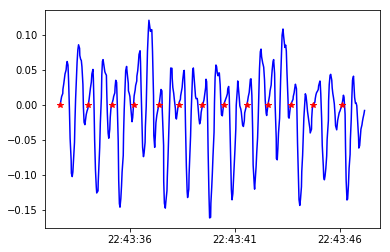

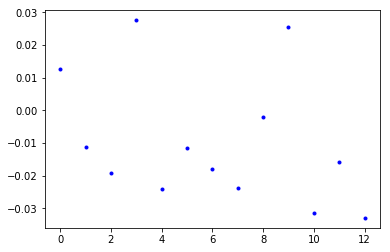

In [85]:
plt.plot(left_data['time'], left_data['Vy'], 'b-')
plt.plot(steps['time'], steps['endVy'], 'r*')
plt.show()
plt.plot(steps['FC'], 'b.')
plt.show()

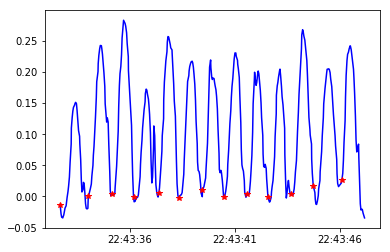

In [86]:
plt.plot(left_data['time'], left_data['Vx'], 'b-')
plt.plot(steps['time'], steps['initVx'], 'r*')
plt.show()